# Evaluating the Overall Pipeline of the Deep Learning based Model

Pipeline: This model firstly fine-tunes a pre-trained DistilBERT transformer with the data in the domain of suicide detection. The extracted embeddings then passed through some custom layers to tell whether a post is suicidal.

In [1]:
# This block is to resolve the inconsistent issue between TensorFlow versions when loading models
import tensorflow as tf

# Set this to the shape of your input array
INPUT_DIM = 2304  # 3 * 768 from your original Reshape

# Define the previously trained model architecture again
def build_custom_classifier():
    inputs = tf.keras.Input(shape=(INPUT_DIM,), name="input")
    x = tf.keras.layers.Reshape((3, -1))(inputs)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(32, activation="relu")(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Load Paths
old_model_path = "./models/BEST_custom_classifier.h5"
new_model_path = "./models/BEST_custom_classifier.keras"

# Build and load weights
model = build_custom_classifier()
model.load_weights(old_model_path)

# Save in .keras format
model.save(new_model_path, save_format="keras")
print(f"✅ Model converted and saved to {new_model_path}")


✅ Model converted and saved to ./models/BEST_custom_classifier.keras


## Import Prerequisite Data

In [2]:
import os
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertModel
import numpy as np
import pandas as pd
import json
DATA_PATH = os.path.realpath(os.path.join("..","data"))
TEST_DATA_PATH = os.path.join(DATA_PATH, 'Depression_Tweets')

# Get the Best Models
models = {}
for modelName in os.listdir('./models'):
    if modelName.endswith('.h5') and modelName.lower().startswith('best') and 'baseline' not in modelName.lower():
        print(f"Loading model: {modelName}")
        # Get the best model path
        best_model_path = os.path.join('.', 'models', modelName)
        # Print the best model path
        print(f"Best Model for {modelName}: {best_model_path}")
        # Store the best model path in the dictionary
        try:
            models[modelName] = tf.keras.models.load_model(best_model_path,compile=False)
        except Exception as e:
            best_model_path = os.path.join('.', 'models', modelName.replace('.h5', '.keras'))
            models[modelName] = tf.keras.models.load_model(best_model_path,compile=False)
    if os.path.isdir(os.path.join('./models', modelName)) and modelName.lower().startswith('best') and 'baseline' not in modelName.lower():
        # Get the best model path
        best_model_path = os.path.join('./models', modelName)
        # Print the best model path
        print(f"Best Model for {modelName}: {best_model_path}")
        # Store the best model path in the dictionary
        if 'encoder' in modelName.lower():
            # Load the encoder model
            models[modelName] = DistilBertTokenizer.from_pretrained(best_model_path)
        else:
            # Load the model using TFDistilBertModel
            models[modelName] = TFDistilBertModel.from_pretrained(best_model_path)

print("✅ Models loaded successfully!")
print(f"Number of models loaded: {len(models)}")
print(f"Models loaded: {list(models.keys())}")

# Get the Resampled Data
X_train_resampled = np.load('./resampled data/X_train_resampled.npy')
X_val_resampled = np.load('./resampled data/X_val_resampled.npy')
y_train_resampled = np.load('./resampled data/y_train_resampled.npy')
y_val_resampled = np.load('./resampled data/y_val_resampled.npy')
X_test = np.load('./resampled data/X_test.npy')
print("✅ Resampled data loaded successfully!")
print(f"X_train_resampled shape: {X_train_resampled.shape}")
print(f"y_train_resampled shape: {y_train_resampled.shape}")
print(f"X_val_resampled shape: {X_val_resampled.shape}")
print(f"y_val_resampled shape: {y_val_resampled.shape}")
print(f"X_test shape: {X_test.shape}")

# Get Raw Test Data
df_test_data = pd.read_json(os.path.join(TEST_DATA_PATH, 'depression_json'))
print("✅ Raw test data loaded successfully!")
print(f"Length of Test Data: {len(df_test_data)}")

c:\Data\Canada\Study\masters\CSI 5386 - Natural Language Processing\Natural-Language-Processing\project-venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading model: BEST_custom_classifier.h5
Best Model for BEST_custom_classifier.h5: .\models\BEST_custom_classifier.h5
Best Model for BEST_fine_tuned_distilBERT_fold_2: ./models\BEST_fine_tuned_distilBERT_fold_2


All model checkpoint layers were used when initializing TFDistilBertModel.

All the layers of TFDistilBertModel were initialized from the model checkpoint at ./models\BEST_fine_tuned_distilBERT_fold_2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


✅ Models loaded successfully!
Number of models loaded: 2
Models loaded: ['BEST_custom_classifier.h5', 'BEST_fine_tuned_distilBERT_fold_2']
✅ Resampled data loaded successfully!
X_train_resampled shape: (6635, 2304)
y_train_resampled shape: (6635,)
X_val_resampled shape: (1611, 2304)
y_val_resampled shape: (1611,)
X_test shape: (18679, 2304)
✅ Raw test data loaded successfully!
Length of Test Data: 18679


## Import Prerequisite Libraries

In [3]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, auc, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## Make Predictions from the Trained Models

From the pipeline, since the resampled data already contain embeddings obtained from the best fine-tuned DistilBERT model, we will use it directly in our custom layers.

In [4]:
# Show the best model's summary
custom_classifier = models['BEST_custom_classifier.h5']
custom_classifier.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2304)]            0         
                                                                 
 reshape (Reshape)           (None, 3, 768)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 128)              426496    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                             

In [5]:
# Predict on the validation set
y_pred_val = custom_classifier.predict(X_val_resampled)
print(f"y_pred_val shape: {y_pred_val.shape}")
print(f"y_val_resampled shape: {y_val_resampled.shape}")

51/51 [==============================] - 1s 3ms/step
y_pred_val shape: (1611, 1)
y_val_resampled shape: (1611,)


We need to flatten the predictions array.

In [6]:
y_pred_val = y_pred_val.flatten()
print(f"y_pred_val shape after flattening: {y_pred_val.shape}")

y_pred_val shape after flattening: (1611,)


## Inspect the values

In [7]:
y_pred_val[:5]

array([0.85953104, 0.7685597 , 0.07050885, 0.9914049 , 0.9756965 ],
      dtype=float32)

Since Tensorflow gives continuous numerics as the prediction outputs, probably the predicted label's probability, we need to convert to an actual label based on the probability.

## Convert Probabilistic Predictions

In [8]:
y_pred_val = np.array([1 if i >= 0.5 else 0 for i in y_pred_val])
print(f"y_pred_val shape after argmax: {y_pred_val.shape}")
print(f"Sample Predictions: {y_pred_val[:5]}")

y_pred_val shape after argmax: (1611,)
Sample Predictions: [1 1 0 1 1]


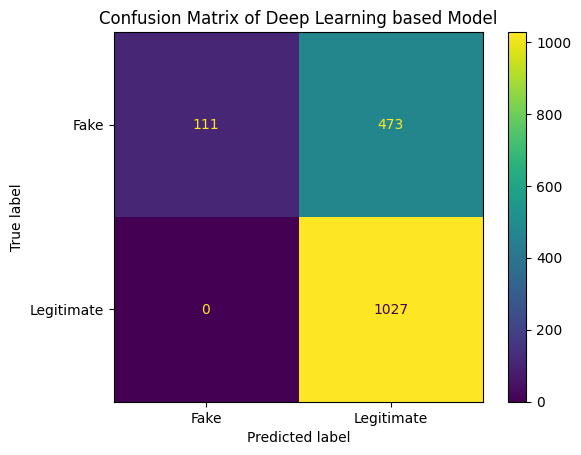

In [9]:
# Confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_true=y_val_resampled,
    y_pred=y_pred_val, cmap='viridis',
    display_labels=['Fake','Legitimate'],
    values_format='d'
)
plt.title('Confusion Matrix of Deep Learning based Model')
plt.savefig('Results/model_2_deep_learning_confusion_matrix.png')
plt.show()

In [10]:
# Compare predictions with ground truths
accuracy = accuracy_score(y_val_resampled, y_pred_val)
precision = precision_score(y_val_resampled, y_pred_val)
recall = recall_score(y_val_resampled, y_pred_val)
macro_f1 = f1_score(y_val_resampled, y_pred_val, average='macro')
micro_f1 = f1_score(y_val_resampled, y_pred_val, average='micro')

# Calculate FPR and TPR for AUC
fpr, tpr, _ = roc_curve(y_val_resampled, y_pred_val)
auc = auc(fpr, tpr) if not np.isnan(fpr).any() and not np.isnan(tpr).any() else 0.0

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Micro F1 Score: {micro_f1:.4f}")
print(f"AUC: {auc:.4f}")

Accuracy: 0.7064
Precision: 0.6847
Recall: 1.0000
Macro F1 Score: 0.5661
Micro F1 Score: 0.7064
AUC: 0.5950


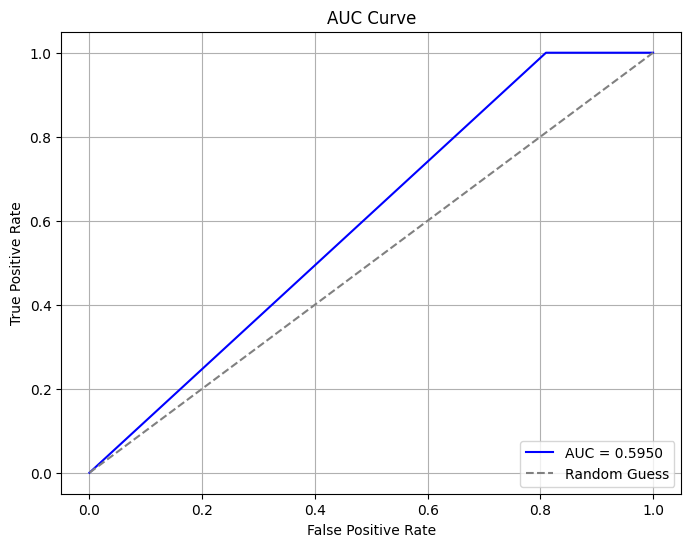

In [11]:
# Plot the AUC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.savefig('Results/model_2_deep_learning_auc_curve.png')
plt.show()

## Predicting on the Test Set

In [12]:
y_pred_test = custom_classifier.predict(X_test)
print(f"y_pred_test shape: {y_pred_test.shape}")

584/584 [==============================] - 2s 3ms/step
y_pred_test shape: (18679, 1)


Since it contains nested lists, we will have to flatten the predictions array.

In [13]:
y_pred_test = y_pred_test.flatten()
print(f"y_pred_test shape after flattening: {y_pred_test.shape}")
print(f"Sample Predictions: {y_pred_test[:5]}")

y_pred_test shape after flattening: (18679,)
Sample Predictions: [0.9964708  0.9981221  0.99825436 0.6237015  0.9986988 ]


Since the predictions array (from a sigmoid function) consists of probabilistic outcomes, we need to convert them to actual labels.

In [14]:
y_pred_test = np.array([1 if i >= 0.5 else 0 for i in y_pred_test])
print(f"y_pred_test shape: {y_pred_test.shape}")
print(f"Sample Predictions: {y_pred_test[:5]}")

y_pred_test shape: (18679,)
Sample Predictions: [1 1 1 1 1]


In [ ]:
# Save the results to a JSONL file
output_file_path = os.path.join(".", "Results", "Result_deep_learning_DistilBERT_model.jsonl")
with open(output_file_path, "w") as jsonl_file:
    for idx, (text, label) in enumerate(zip(df_test_data["content"], y_pred_test)):
        jsonl_file.write(json.dumps(
            {
                'id': idx,
                'predicted_label': int(label),
                'raw_text': text
            }
        ) + "\n")
print(f"✅ Results are saved to {output_file_path}")

✅ Results are saved to .\Results\Result_hybrid_model.jsonl
